Mounting the fastai platform on Google Drive


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Mount the Google Drive on Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


Convert all the .jfif files to jpeg to ensure consistency


In [0]:
# !sudo apt install imagemagick
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/test/'; mogrify -format jpg *.jfif
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/healthy_wheat'; mogrify -format jpg *.jfif  
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/leaf_rust'; mogrify -format jpg *.jfif  
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/stem_rust'; mogrify -format jpg *.jfif  

Import the required libraries

In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Define the path on Google Drive


In [0]:
path = Path(base_dir + 'wheat_rust/')
path.ls()



[PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/train'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission1.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission2.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission3.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission4.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission5.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission6.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission7.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission8.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission10.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_

Create the ImageDataBunch from the folders on Google Drive

In [0]:
np.random.seed(42)

tfms = get_transforms(flip_vert=True, max_lighting=0.4, xtra_tfms=[*zoom_crop(scale=(0.75,1), do_rand=True)])

data = ImageDataBunch.from_folder( path/'train', train='.', test='../test'
               , valid_pct=0.1, bs=32, size=64, ds_tfms=tfms)
data.classes

['healthy_wheat', 'leaf_rust', 'stem_rust']

View random sample of the images

In [0]:
# data.show_batch(rows=3, figsize=(7,8))

In [0]:
class Log_loss(Callback):

  def on_epoch_begin(self, **kwargs):
    self.count, self.val = 0., 0.

  def on_batch_end(self, last_output, last_target, **kwargs):
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0)
        loss = F.cross_entropy(last_output, *last_target)
        
        self.val += last_target[0].size(0) * loss.detach().cpu()

  def on_epoch_end(self, last_metrics, **kwargs):
    "Set the final result in `last_metrics`."
    return add_metrics(last_metrics, self.val/self.count)

Build the Learner

In [0]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy,Log_loss()]).mixup()

In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Fit the top layer of the model

In [0]:
learn.fit_one_cycle(40, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,1.805873,1.043844,0.471264,0.528736,1.043844,00:11
1,1.666691,1.058434,0.390805,0.609195,1.058434,00:08
2,1.556566,0.984043,0.379310,0.620690,0.984043,00:08
3,1.431273,1.130083,0.333333,0.666667,1.130083,00:09
4,1.316165,1.437388,0.344828,0.655172,1.437388,00:08
5,1.194945,1.797043,0.356322,0.643678,1.797043,00:08
6,1.092242,1.118698,0.333333,0.666667,1.118698,00:08
7,1.069512,0.766091,0.275862,0.724138,0.766090,00:09
8,1.055036,1.882990,0.333333,0.666667,1.882990,00:08
9,1.080523,1.797968,0.275862,0.724138,1.797968,00:08


Save the stage-1 of the model

In [0]:
learn.save('stage-1-64')

Unfreeze the transfer learning model so better results can be obtained


In [0]:
learn.unfreeze()

Finding the optimum learning rate

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Determine the best from the plot

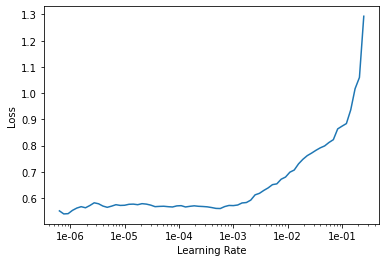

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

Re-fitting the model for deeper layers

In [0]:
learn.fit_one_cycle(25, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,0.575321,0.634545,0.183908,0.816092,0.634545,00:09
1,0.580842,0.707789,0.160920,0.839080,0.707789,00:09
2,0.566615,0.813389,0.137931,0.862069,0.813389,00:09
3,0.555818,0.725142,0.160920,0.839080,0.725142,00:09
4,0.552619,0.562274,0.160920,0.839080,0.562274,00:09
5,0.557445,0.656462,0.160920,0.839080,0.656462,00:09
6,0.558605,0.635981,0.160920,0.839080,0.635981,00:09
7,0.558529,0.573008,0.160920,0.839080,0.573008,00:09
8,0.554308,0.587796,0.172414,0.827586,0.587796,00:09
9,0.554232,0.643016,0.149425,0.850575,0.643016,00:09


In [0]:
learn.save('stage-2-64')

Load the new saved model

In [0]:
# learn.load('stage-2-64');

Interpreting the model

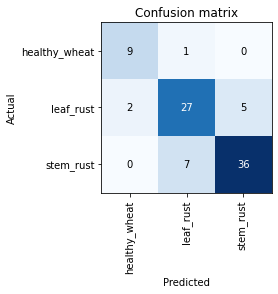

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [0]:
# np.random.seed(42)

# data = ImageDataBunch.from_folder( path/'train', train='.', test='../test'
#                , valid_pct=0.1, bs=32, size=128, ds_tfms=tfms)

# learn.data = data
# data.train_ds[0][0].shape

In [0]:
# learn.freeze()
# learn.lr_find()


In [0]:
# learn.recorder.plot()

In [0]:
lr=1e-5/2


In [0]:
# learn.fit_one_cycle(25, slice(lr))


In [0]:
# learn.save('stage-1-128-rn50')


In [0]:
# learn.unfreeze()


In [0]:
# learn.fit_one_cycle(25, slice(1e-5, lr/5))


In [0]:
# learn.recorder.plot_losses()


In [0]:
# learn.save('stage-2-128-rn50')


build a third model with size increased


In [0]:
np.random.seed(42)

tfms = get_transforms(flip_vert=True, max_lighting=0.4, xtra_tfms=[*zoom_crop(scale=(0.75,1), do_rand=True)])

data = ImageDataBunch.from_folder( path/'train', train='.', test='../test'
               , valid_pct=0.1, bs=32, size=220, ds_tfms=tfms)
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 220, 220])

In [0]:
learn.freeze()
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


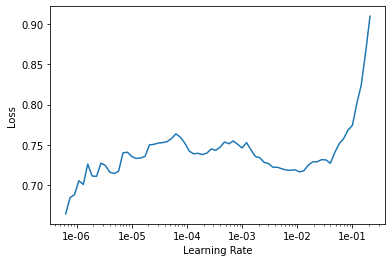

In [0]:
learn.recorder.plot()

In [0]:
lr=1e-5/2
learn.fit_one_cycle(30, slice(lr))


epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,0.791089,0.457312,0.160920,0.839080,0.457312,00:15
1,0.764667,0.425243,0.172414,0.827586,0.425243,00:14
2,0.743410,0.470028,0.195402,0.804598,0.470028,00:14
3,0.747329,0.422679,0.183908,0.816092,0.422679,00:14
4,0.750170,0.451522,0.172414,0.827586,0.451522,00:14
5,0.736415,0.441710,0.183908,0.816092,0.441710,00:14
6,0.737176,0.446340,0.160920,0.839080,0.446340,00:13
7,0.737139,0.403660,0.160920,0.839080,0.403660,00:14
8,0.744497,0.436366,0.172414,0.827586,0.436366,00:14
9,0.747499,0.427640,0.160920,0.839080,0.427640,00:14


In [0]:
learn.save('stage-1-220-rn50')
learn.unfreeze()


In [0]:
learn.fit_one_cycle(30, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,0.721395,0.432236,0.149425,0.850575,0.432236,00:17
1,0.722543,0.418786,0.160920,0.839080,0.418786,00:16
2,0.708555,0.424304,0.160920,0.839080,0.424304,00:16
3,0.720501,0.436668,0.149425,0.850575,0.436668,00:16
4,0.703366,0.408552,0.126437,0.873563,0.408552,00:16
5,0.681968,0.442242,0.126437,0.873563,0.442242,00:16
6,0.678691,0.414120,0.126437,0.873563,0.414120,00:16
7,0.670906,0.373341,0.114943,0.885057,0.373341,00:16
8,0.663310,0.378689,0.126437,0.873563,0.378689,00:16
9,0.656978,0.381791,0.114943,0.885057,0.381791,00:16


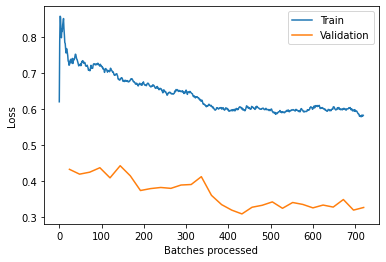

In [0]:
learn.recorder.plot_losses()


In [0]:
learn.save('stage-2-220-rn50')


In [0]:
learn.load('stage-2-220-rn50')

AttributeError: ignored

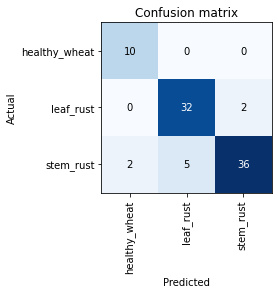

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [0]:
# learn.load('stage-2-128-rn50')


Making predictions on the test dataset

In [0]:
learn.export()
preds, y = learn.get_preds(ds_type=DatasetType.Test)



Save Predictions

In [0]:
import os

submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir('/content/gdrive/My Drive/fastai-v3/wheat_rust/test/')  if s.split('.')[1] != 'jfif']})
for i, c in enumerate(learn.data.classes):
  submission[c] = preds[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission.head()


,ID,leaf_rust,stem_rust,healthy_wheat
0,1NCGYL,0.459957,0.450102,0.089940
1,0JIX2C,0.041196,0.957829,0.000975
2,008FWT,0.601709,0.271955,0.126336
3,26MSDN,0.513459,0.462005,0.024537
4,00AQXY,0.043497,0.951336,0.005167


In [0]:
print(len(submission))
submission.to_csv('/content/gdrive/My Drive/fastai-v3/wheat_rust/results2.csv', index=False)

620
